# Cuaderno de presentación prueba NLP Davivienda

En este cuaderno se hace una breve descripción de aspectos relevantes obtenidos en los tweets.

In [1]:
#!pip install spacy
#!python -m spacy download es_core_news_sm
#!pip install transformers
#!pip install tensorflow
#!pip install bs4
#!pip install networkx
#!pip install gensim
#!pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import plotly.express as px
import plotly.graph_objects as go

import spacy
import es_core_news_sm
nlp=spacy.load("es_core_news_sm")
from spacy import displacy

import gensim 
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models import LdaMulticore
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import Phrases
from gensim.models import LdaSeqModel
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation


import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

import urllib
from bs4 import BeautifulSoup

import transformers
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig


import networkx as nx
from networkx.algorithms import community

import warnings
warnings.filterwarnings("ignore")



In [3]:
## Lectura de datos

df_tweets = pd.read_csv("../Datos/davivienda_tweets.csv")
df_tweets.head()

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


In [ ]:
## Limpieza de datos
## Iniciamos extrayendo caracteres especiales (\n)

df_tweets['Embedded_text_1'] = df_tweets['Embedded_text'].apply(lambda x: re.sub(r'\n[ 0-9]*', ' ', x))

## Luego extraemos los links
df_tweets['links'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'http\S+', x))
links_title=[]
for i in df_tweets['links']:
    if len(i)==0:
        links_title.append("")
    else:
        lista_i=[]
        for k in i:
            #print(k)
            try:
                html_page = urllib.request.urlopen(k)
                soup = BeautifulSoup(html_page)
                lista_i.append(soup.title.string)
            except:
               new_k=k.replace("https://","")
               new_k=new_k.replace("http://","")
               new_k=re.sub(r'\.[A-Za-z\.]*', '', new_k)
               new_k=re.sub(r'\/.*', '', new_k)
               lista_i.append(new_k)
        links_title.append(lista_i)

df_tweets['links_title']=links_title
df_tweets['conteo_links'] = df_tweets['links'].apply(lambda x: len(x))
df_tweets['Embedded_text_1'] = df_tweets['Embedded_text_1'].apply(lambda x: re.sub(r'http\S+', 'Link_aqui', x))

## Luego extraemos los hashtags
df_tweets['hashtags'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'#\S+', x))
df_tweets['conteo_hashtags'] = df_tweets['hashtags'].apply(lambda x: len(x))

## Luego extraemos los menciones
df_tweets['menciones'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'@\S+', x))
df_tweets['menciones'] = [[re.sub("[^0-9A-Za-z\_\-@]","",men.lower()) for men in k] for k in df_tweets['menciones']]
df_tweets['conteo_menciones'] = df_tweets['menciones'].apply(lambda x: len(x))

df_tweets['UserName']=df_tweets['UserName'].apply(lambda x: re.sub("[^0-9A-Za-z\_\-@]","",x.lower()))


In [5]:
## Luego extraemos los emojis
df_tweets['emojis'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'\\u\S+', x))
df_tweets['conteo_emojis'] = df_tweets['emojis'].apply(lambda x: len(x))

## Luego extraemos los RT
df_tweets['RT'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'RT', x))
df_tweets['conteo_RT'] = df_tweets['RT'].apply(lambda x: len(x))



In [6]:
## Análisis de sentimientos

## Cargamos el modelo de sentimientos

from transformers import pipeline
nlp_sentiment = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

## Aplicamos el modelo a los tweets

df_tweets['sentiment'] = df_tweets['Embedded_text_1'].apply(lambda x: nlp_sentiment(x)[0]['label'])
df_tweets['sentiment_score'] = df_tweets['Embedded_text_1'].apply(lambda x: nlp_sentiment(x)[0]['score'])


2022-11-08 20:17:44.059500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [7]:
df_tweets['sentiment'].value_counts()

1 star     1250
5 stars     314
4 stars     152
3 stars      51
2 stars      44
Name: sentiment, dtype: int64

In [8]:
df_tweets['sentiment_score'].describe()

count    1811.000000
mean        0.546778
std         0.188656
min         0.219787
25%         0.389547
50%         0.513138
75%         0.697739
max         0.971901
Name: sentiment_score, dtype: float64

In [9]:
df_tweets['menciones']

0                               []
1                               []
2                    [@davivienda]
3       [@davivienda, @davivienda]
4                    [@davivienda]
                   ...            
1806                [@jaimemolina]
1807                   [@josefe71]
1808                  [@gleniiaaa]
1809                  [@diegoruix]
1810                  [@diegoruix]
Name: menciones, Length: 1811, dtype: object

In [10]:
## Creamos redes para identificar relaciones entre usuarios. Empezamos por la mención de usuarios.
list_df=[]
for i in range(len(df_tweets)):
    for j in df_tweets['menciones'][i]:
            df_edges_mencion_temp=pd.DataFrame(data={'Source':[df_tweets['UserName'][i]],'Target':[j],'Weight':[1],'Type':['Mencion']})
            list_df.append(df_edges_mencion_temp)
df_edges_mencion=pd.concat(list_df)
df_edges_mencion=df_edges_mencion.groupby(['Source','Target','Type']).sum().reset_index()



In [11]:
df_edges_mencion

,Source,Target,Type,Weight
0,@04elisabeth,@asnasalvaje,Mencion,1
1,@04elisabeth,@davivienda,Mencion,5
2,@04elisabeth,@sfcsupervisor,Mencion,1
3,@04elisabeth,@sicsuper,Mencion,1
4,@04elisabeth,@wilsonariasc,Mencion,1
...,...,...,...,...
2376,h@ner,@bancolombia,Mencion,1
2377,h@ner,@davivienda,Mencion,1
2378,karen-aleja-287@hotmailcom,@davivienda,Mencion,1
2379,profedellanterawilburbloqueadopor@ca_acosta,@fervarelahn,Mencion,1


In [12]:
## Seguimos por la co ocurrencia en tweets
df_edges_relacion=pd.DataFrame(columns=['Source','Target','Weight','Type'])
list_source=[]
list_target=[]
list_weight=[]
list_type=[]
for i in df_tweets['menciones']:
    if len(i)>0:
        n=len(i)
        for k in range(n-1):
            for j in range(k+1,n):
                if i[k]!=i[j]:
                    list_source.append(i[k])
                    list_target.append(i[j])
                    list_weight.append(1)
                    list_type.append("undirected")
df_edges_relacion['Source']=list_source
df_edges_relacion['Target']=list_target
df_edges_relacion['Weight']=list_weight
df_edges_relacion['Type']=list_type
df_edges_relacion=df_edges_relacion.groupby(['Source','Target','Type']).sum().reset_index()

df_edges_relacion.to_csv("../Datos/relacion_menciones.csv",index=False)

df_users_menciones=pd.DataFrame(columns=['Id','Label','Weight','Type'])
list_id=[]
list_label=[]
list_weight=[]
list_type=[]
for i in df_tweets['menciones']:
    if len(i)>0:
        for k in i:
            list_id.append(k)
            list_label.append(k)
            list_weight.append(1)
            list_type.append("Undirected")
df_users_menciones['Id']=list_id
df_users_menciones['Label']=list_label
df_users_menciones['Weight']=list_weight
df_users_menciones['Type']=list_type
df_users_menciones=df_users_menciones.groupby(['Id','Label','Type']).sum().reset_index()

df_users_menciones.to_csv("../Datos/usuarios_menciones.csv",index=False)



In [13]:
## Veamos las relaciones de usuarios en mapas de calor

df_heat_map=df_edges_mencion.groupby(['Source','Target']).sum().reset_index()
df_heat_map=df_heat_map.pivot(index='Source',columns='Target',values='Weight')
df_heat_map=df_heat_map.fillna(0)



In [14]:
df_heat_map[((df_heat_map>0).sum()[(df_heat_map>0).sum()>3]).index]

Target,@an4cr0s,@andrescepeda,@asnasalvaje,@augustoocampo,@banco_avvillas,@bancodebogota,@bancolombia,@bancosaval,@bbva,@binance,...,@petrogustavo,@prosperidadcol,@scotiacolpatria,@segurosbolivar,@sfcsupervisor,@sicsuper,@ssf_elsalvador,@susanacorreabor,@telefonorojo,@wilsonariasc
Source,,,,,,,,,,,,,,,,,,,,,
@04elisabeth,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
@0kh0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@1almejandra4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@21mrniceguy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@24ricardov,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
@ztebenzoacha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
@zuchimal,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
h@ner,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(35, 53)


<AxesSubplot: xlabel='Target', ylabel='Source'>

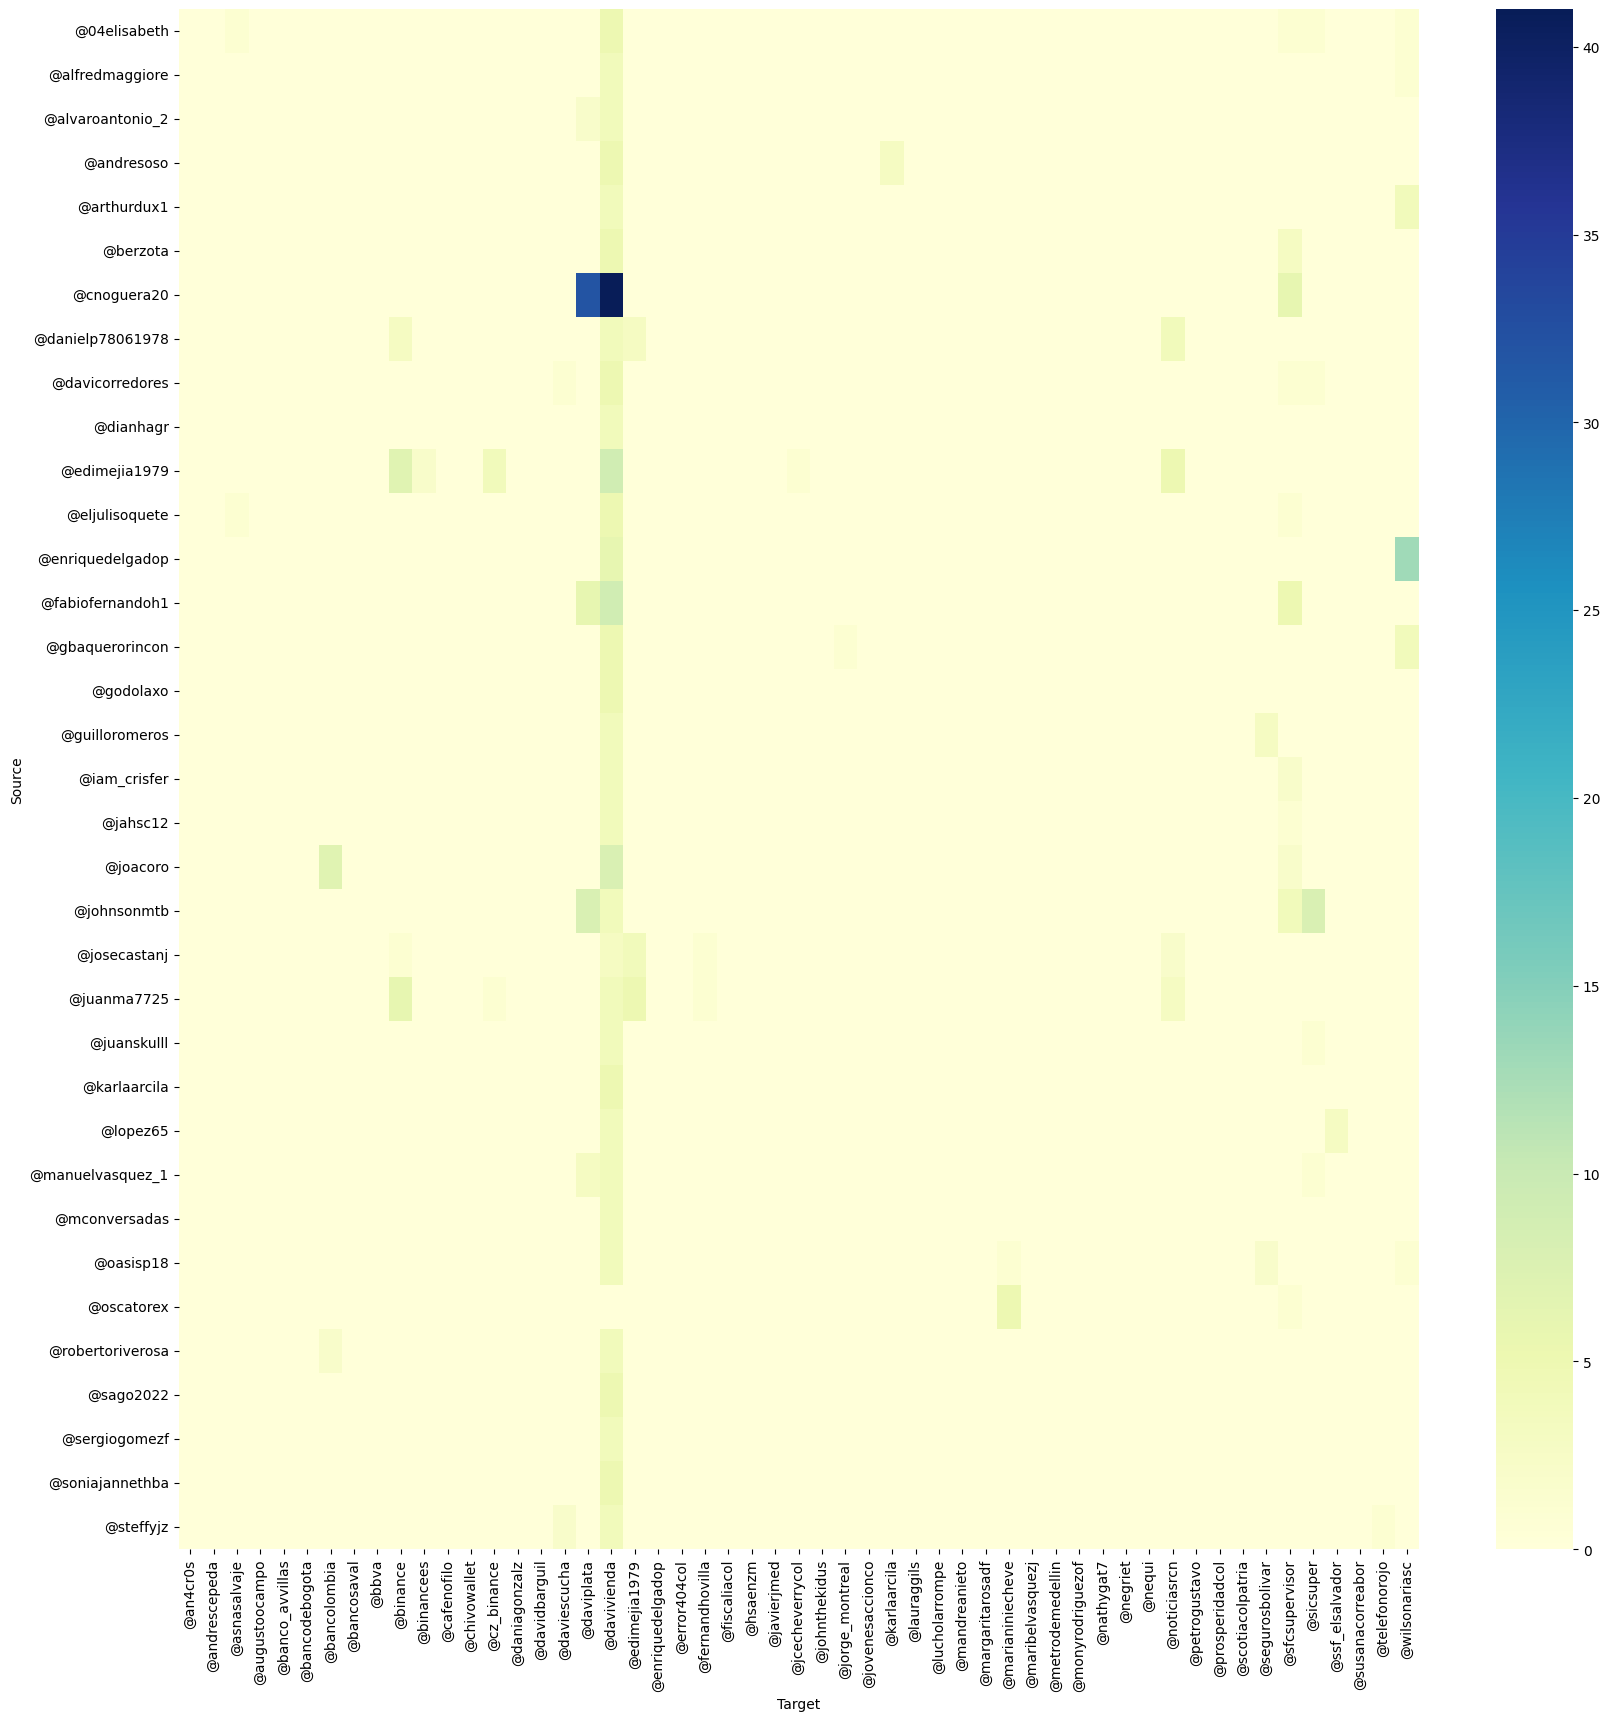

In [15]:
df_columns_heatmap=df_heat_map[((df_heat_map>0).sum()[(df_heat_map>0).sum()>3]).index]
df_columns_heatmap=df_columns_heatmap[((df_columns_heatmap>3).sum(axis=1)>0)]
print(df_columns_heatmap.shape)

plt.figure(figsize=(20,20))
sns.heatmap(df_columns_heatmap,cmap="YlGnBu")

In [16]:
df_1=df_edges_mencion[df_edges_mencion['Source'].isin(df_columns_heatmap.index)]
df_1=df_1[df_1['Target'].isin(df_columns_heatmap.columns)]
df_1

,Source,Target,Type,Weight
0,@04elisabeth,@asnasalvaje,Mencion,1
1,@04elisabeth,@davivienda,Mencion,5
2,@04elisabeth,@sfcsupervisor,Mencion,1
3,@04elisabeth,@sicsuper,Mencion,1
4,@04elisabeth,@wilsonariasc,Mencion,1
...,...,...,...,...
2170,@sergiogomezf,@davivienda,Mencion,4
2200,@soniajannethba,@davivienda,Mencion,5
2231,@steffyjz,@daviescucha,Mencion,2
2232,@steffyjz,@davivienda,Mencion,4


In [17]:
labels_df1=enumerate(list(set(list(df_1.Source)+list(df_1.Target))))
labels_df1=dict((y,x) for x,y in labels_df1)

df_1['Source_num']=df_1['Source'].apply(lambda x: labels_df1[x])
df_1['Target_num']=df_1['Target'].apply(lambda x: labels_df1[x])

In [18]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(set(list(df_1.Source)+list(df_1.Target)))
    ),
    link = dict(
      source = df_1['Source_num'], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = df_1['Target_num'],
      value = df_1['Weight']
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [19]:
## Veamos las relaciones de usuarios agrupando y ordenando por cantidad de menciones

df_agrupacion_fuente=df_edges_mencion.groupby(['Source']).agg({'Target':'count','Weight':'sum'}).reset_index()
df_agrupacion_fuente.columns=['Source','Usuarios mencionados','Total de menciones']
df_agrupacion_fuente.sort_values(by=['Usuarios mencionados'],ascending=False,inplace=True)
df_agrupacion_fuente.head(20)

,Source,Usuarios mencionados,Total de menciones
261,@davivienda,208,248
601,@juanma7725,11,27
940,@santini_es,10,10
251,@davicorredores,10,22
440,@guilloromeros,9,22
555,@johnsonmtb,8,40
234,@damarismarino,8,8
314,@edimejia1979,8,32
356,@enriquedelgadop,7,24
617,@julioorozco29,7,10


In [20]:
df_agrupacion_mencionados=df_edges_mencion.groupby(['Target']).agg({'Source':'count','Weight':'sum'}).reset_index()
df_agrupacion_mencionados.columns=['Target','Usuarios que lo mencionaron','Total de menciones']
df_agrupacion_mencionados.sort_values(by=['Usuarios que lo mencionaron'],ascending=False,inplace=True)
df_agrupacion_mencionados.head(20)

,Target,Usuarios que lo mencionaron,Total de menciones
212,@davivienda,746,1103
832,@wilsonariasc,80,106
752,@sfcsupervisor,63,88
211,@daviplata,57,121
554,@marianiniecheve,53,60
71,@asnasalvaje,45,47
93,@bancolombia,44,54
744,@segurosbolivar,32,39
756,@sicsuper,20,27
473,@karlaarcila,20,25


In [21]:
user_relaciones=df_users_menciones[df_users_menciones['Weight']>3]
edges_relaciones=df_edges_relacion[df_edges_relacion['Weight']>3]


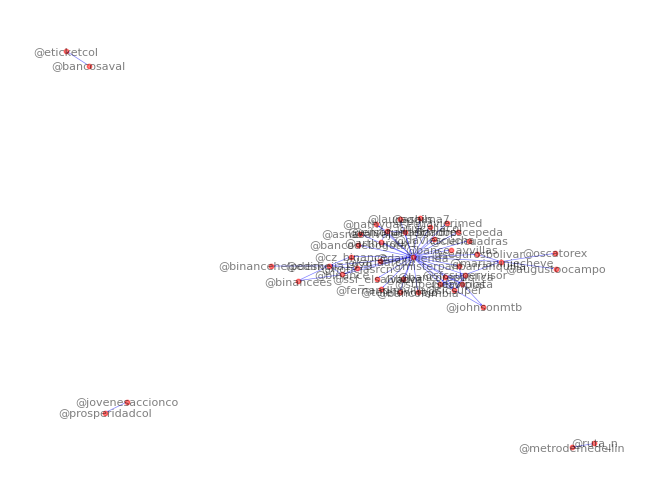

In [22]:
### Pintamos las redes

#nodes=user_relaciones[['Id','Label']]
edges=edges_relaciones[['Source','Target','Weight']]
G=nx.from_pandas_edgelist(edges, 'Source', 'Target', edge_attr=True, create_using=nx.Graph())
#G.add_nodes_from(nodes['Id'].values)
nx.draw(G, with_labels=True, node_size=10, font_size=8, node_color='red', edge_color='blue', width=0.5, alpha=0.5, arrowsize=1, arrowstyle='->', arrows=True)



In [23]:
## Guardamos la información lograda hasta ahora
df_tweets.to_csv("../Datos/tweets_procesados.csv",index=False)
df_users_menciones.to_csv("../Datos/usuarios_menciones.csv",index=False)
df_edges_mencion.to_csv("../Datos/relacion_menciones.csv",index=False)
df_edges_relacion.to_csv("../Datos/relacion_mencionados.csv",index=False)



In [24]:
## Hacemos un análisis de temas utilizando topic modeling
## Preparamos los datos para el análisis de temas

### Eliminamos los tweets que no tienen texto

df_tweets_2=df_tweets.copy()
df_tweets_2=df_tweets_2[df_tweets_2['Embedded_text'].notnull()]
df_tweets_2=df_tweets_2[df_tweets_2['Embedded_text']!='']

### procesamos el texto

df_tweets_2['processed_text']=df_tweets_2['Embedded_text'].apply(lambda x: x.lower())
df_tweets_2['processed_text']=df_tweets_2['processed_text'].apply(lambda x: re.sub(r'[^a-z0-9áéíóúñü@# ]', '', x))
df_tweets_2['processed_text']=df_tweets_2['processed_text'].apply(lambda x: re.sub(r' +', ' ', x))
df_tweets_2['processed_text']=df_tweets_2['processed_text'].apply(lambda x: x.strip())

stopwords_es = nltk.corpus.stopwords.words('spanish')

In [25]:
def tokenize(text: str) -> str:
    """Tokenize given text"""
    
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation]
    text = preprocess_string(text, CUSTOM_FILTERS)

    return text


In [26]:
nlp_spacy=spacy.load('es_core_news_sm')
def lemmatize_spacy(text: str) -> str:
    """Lemmatize given text"""
    return " ".join([token.lemma_ for token in nlp_spacy(text)])

doc_lemma = [lemmatize_spacy(doc) for doc in df_tweets_2['processed_text'].values]
doc_tokens = [tokenize(doc) for doc in doc_lemma]
bigram = gensim.models.Phrases(doc_tokens, threshold=100, min_count=5)
doc_bigram = [bigram[doc_tokens[i]] for i in range(len(doc_tokens))]

In [27]:
doc_list=[]
for sent in doc_bigram:
    new_doc = [str(word) for word in sent if word not in stopwords_es and len(word)>3]
    doc_list.append(new_doc)
df_tweets_2['processed_text']=doc_list

### Creamos el diccionario y el corpus

dictionary = corpora.Dictionary(df_tweets_2['processed_text'].values)
corpus = [dictionary.doc2bow(text) for text in df_tweets_2['processed_text'].values]


In [28]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [29]:
### amplicamos el modelo

best_num=0
best_coherence=0

for i in range(2,10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=i,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    coherence_model=CoherenceModel(model=lda_model, texts=df_tweets_2['processed_text'].values, dictionary=dictionary, coherence='c_v')
    coherence=coherence_model.get_coherence()
    print("Coherence score for {} topics: {}".format(i, coherence))

    if coherence>best_coherence:
        print("grupos {} y coherencia: {}".format(i,coherence))
        best_num =i
        best_coherence=coherence

print("El mejor puntaje de coherence es {} para {} temas".format(best_coherence,best_num))




Coherence score for 2 topics: 0.5109197310138296
grupos 2 y coherencia: 0.5109197310138296
Coherence score for 3 topics: 0.5165521422669112
grupos 3 y coherencia: 0.5165521422669112
Coherence score for 4 topics: 0.5199353436102598
grupos 4 y coherencia: 0.5199353436102598
Coherence score for 5 topics: 0.47985086404616134
Coherence score for 6 topics: 0.45559158899934604
Coherence score for 7 topics: 0.4929380739112959
Coherence score for 8 topics: 0.5055075162340867
Coherence score for 9 topics: 0.4995579929499534
El mejor puntaje de coherence es 0.5199353436102598 para 4 temas


In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=best_num,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

for topic in lda_model.print_topics():
    print(topic)


(0, '0.044*"respuesta" + 0.022*"wilsonariasc" + 0.015*"davivienda" + 0.010*"daviviendir" + 0.007*"banco" + 0.007*"lugar_equivocado" + 0.006*"hablar" + 0.005*"daviviendano" + 0.005*"lugar" + 0.004*"empresa"')
(1, '0.040*"davivienda" + 0.037*"respuesta" + 0.022*"hacer" + 0.021*"tener" + 0.018*"haber" + 0.016*"cuenta" + 0.012*"poder" + 0.012*"banco" + 0.012*"daviviendo" + 0.011*"daviplata"')
(2, '0.059*"respuesta" + 0.057*"mensaje" + 0.043*"privado" + 0.040*"caso" + 0.022*"ayudar" + 0.020*"quedar_atento" + 0.020*"validar" + 0.018*"tarde" + 0.018*"detalle" + 0.015*"gusto"')
(3, '0.031*"responder" + 0.007*"navidad" + 0.007*"mencionar" + 0.007*"llegar" + 0.006*"cobrar" + 0.004*"bien" + 0.004*"daviviendir" + 0.004*"daviviendo" + 0.004*"comercial" + 0.004*"prueba"')


In [31]:
### Guardamos el modelo

lda_model.save("../Datos/lda_model.model")
dictionary.save("../Datos/dictionary.dict")
corpora.MmCorpus.serialize('../Datos/corpus.mm', corpus)


In [32]:
topic_dist = lda_model[corpus]

# Agregar distribución de temas a los datos
df_tweets_2['Distribución de temas'] = [x for x in topic_dist]


# Identificar el tema más probable para cada tweet
Lista_temas=[]
for i in df_tweets_2['Distribución de temas']:
    df_temp=pd.DataFrame(i[0])
    df_temp.columns=['Tema','Probabilidad']
    df_temp.sort_values(by='Probabilidad',ascending=False,inplace=True)
    Lista_temas.append(df_temp.iloc[0,0])
df_tweets_2['Tema más probable']=Lista_temas

# Guardar los datos
df_tweets_2.to_csv("../Datos/tweets_procesados_temas.csv",index=False)


In [53]:
### Visualización de los temas

pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, dictionary=dictionary, corpus=corpus)
vis

/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/izainea/miniconda3/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.120862  0.214129       1        1  50.605828
2      0.318844  0.009030       2        1  20.351592
3     -0.107974 -0.162254       3        1  14.574322
0     -0.090008 -0.060905       4        1  14.468259, topic_info=            Term        Freq       Total Category  logprob  loglift
333      mensaje  294.000000  294.000000  Default  30.0000  30.0000
178    respuesta  944.000000  944.000000  Default  29.0000  29.0000
708      privado  221.000000  221.000000  Default  28.0000  28.0000
690         caso  206.000000  206.000000  Default  27.0000  27.0000
7     davivienda  564.000000  564.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
178    respuesta  161.686440  944.348603   Topic4  -3.1235   0.1684
37   daviviendir   35.182990   95.280229   Topic4  -4.6486   0.9370
7     davivienda   54.171472  564.636410   Topic4  -4.2170  -0.4108
23         banco   24.897109  182.269672   Topic4  -4.9944  -0.0575
108      conocer    8.539007   17.167386   Topic4  -6.0645   1.2348

[177 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
3531      2  0.976082  antemano_ofrecer
2224      2  0.438448          anterior
2224      3  0.535880          anterior
2232      3  0.704923              aquí
2232      4  0.271124              aquí
...     ...       ...               ...
900       3  0.951732              vida
2261      1  0.081368             vivir
2261      4  0.895050             vivir
4817      1  0.246836      wilsonariasc
4817      4  0.749649      wilsonariasc

[164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [34]:
df_tweets_2['Tema más probable'].value_counts()

1    947
0    316
2    304
3    244
Name: Tema más probable, dtype: int64

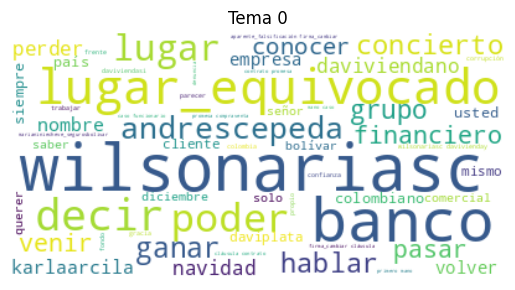

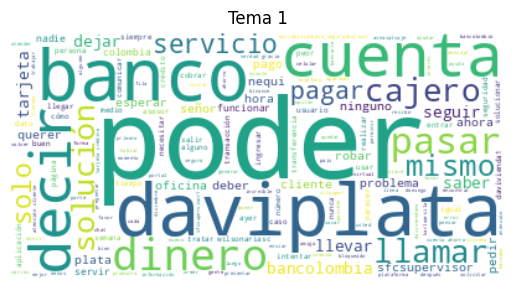

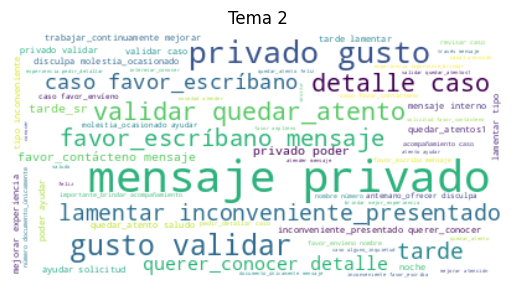

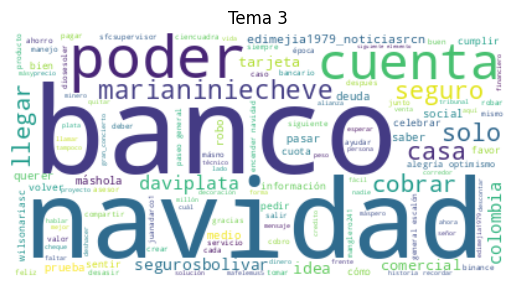

In [35]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

for i in range(4):
    df_temp=df_tweets_2[df_tweets_2['Tema más probable']==i]
    text = " ".join([" ".join(review).lower() for review in df_temp['processed_text']])

    stopwords = stopwords_es
    stopwords = list(stopwords)+['davivienda','daviviendo','daviviendir',
    'respuesta','responder','hacer','haber','tener']

    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Tema {}".format(i))
    plt.show()



In [36]:
label_temas={0:'Tweets con información que afecta a la opinión pública',
            1:'Dificultades de acceso al dinero',
            2:'Tweets que requieren procesos para validar información',
            3:'Tweets que de campañas publicitarias'}

## Resumen y entrega de resultados

Información exploratoria

In [37]:
df_tweets_2['Retweets']=df_tweets_2['Retweets'].fillna(0)

Lista_rt=[]
for i in df_tweets_2['Retweets']:
    if type(i)==int:
        Lista_rt.append(i)
    else:
        if i.count('mil')>0:
            i=i.replace('mil','000').replace(',','').replace(' ','')
        i=int(i)
        Lista_rt.append(i)
df_tweets_2['Retweets']=Lista_rt

df_tweets_2['Likes']=df_tweets_2['Likes'].fillna(0)
Lista_likes=[]
for i in df_tweets_2['Likes']:
    if type(i)==int:
        Lista_likes.append(i)
    else:
        if i.count('mil')>0:
            i=i.replace('mil','000').replace(',','').replace(' ','')
        i=int(i)
        Lista_likes.append(i)
df_tweets_2['Likes']=Lista_likes

In [38]:
## Exploraremos la base df_tweets_2

tweets=df_tweets_2.shape
print("La base de datos tiene {} tweets.".format(tweets[0]))

usuarios=df_tweets_2['UserName'].nunique()
print("La base de datos registra los tweets de {} usuarios".format(usuarios))
print("El número aproximado de tweets por usuario es de {:.2f}.".format(tweets[0]/usuarios))

comen=df_tweets_2['Comments'].sum()
print("La base de datos registra {} comentarios.".format(comen))

retw=df_tweets_2['Retweets'].sum()
print("La base de datos registra {} retweets.".format(retw))

likes=df_tweets_2['Likes'].sum()
print("La base de datos registra {} likes.".format(likes))

links_num=df_tweets['conteo_links'].sum()
print("La base de datos registra {} links mencionados.".format(links_num))

hashtags_num=df_tweets['conteo_hashtags'].sum()
print("La base de datos registra {} hashtags.".format(hashtags_num))
usuarios_mencionados=set()
for i in df_tweets_2['menciones']:
    new_set=set(i) 
    usuarios_mencionados=usuarios_mencionados.union(new_set)

menciones_num=df_tweets['conteo_menciones'].sum()
print("La base de datos registra {} menciones a {} usuarios.".format(menciones_num,len(usuarios_mencionados)))


La base de datos tiene 1811 tweets.
La base de datos registra los tweets de 1168 usuarios
El número aproximado de tweets por usuario es de 1.55.
La base de datos registra 1267.0 comentarios.
La base de datos registra 29364 retweets.
La base de datos registra 16830 likes.
La base de datos registra 63 links mencionados.
La base de datos registra 222 hashtags.
La base de datos registra 3102 menciones a 854 usuarios.


In [39]:
df_tweets_2['UserName'].value_counts()

@davivienda         245
@cnoguera20          41
@davicorredores      23
@edimejia1979         9
@juanma7725           8
                   ... 
@andrescepeda         1
@urcuchillay_1        1
@angelacbas           1
@carlosgutierrca      1
@soyinfanterubio      1
Name: UserName, Length: 1168, dtype: int64

<AxesSubplot: xlabel='Target', ylabel='Source'>

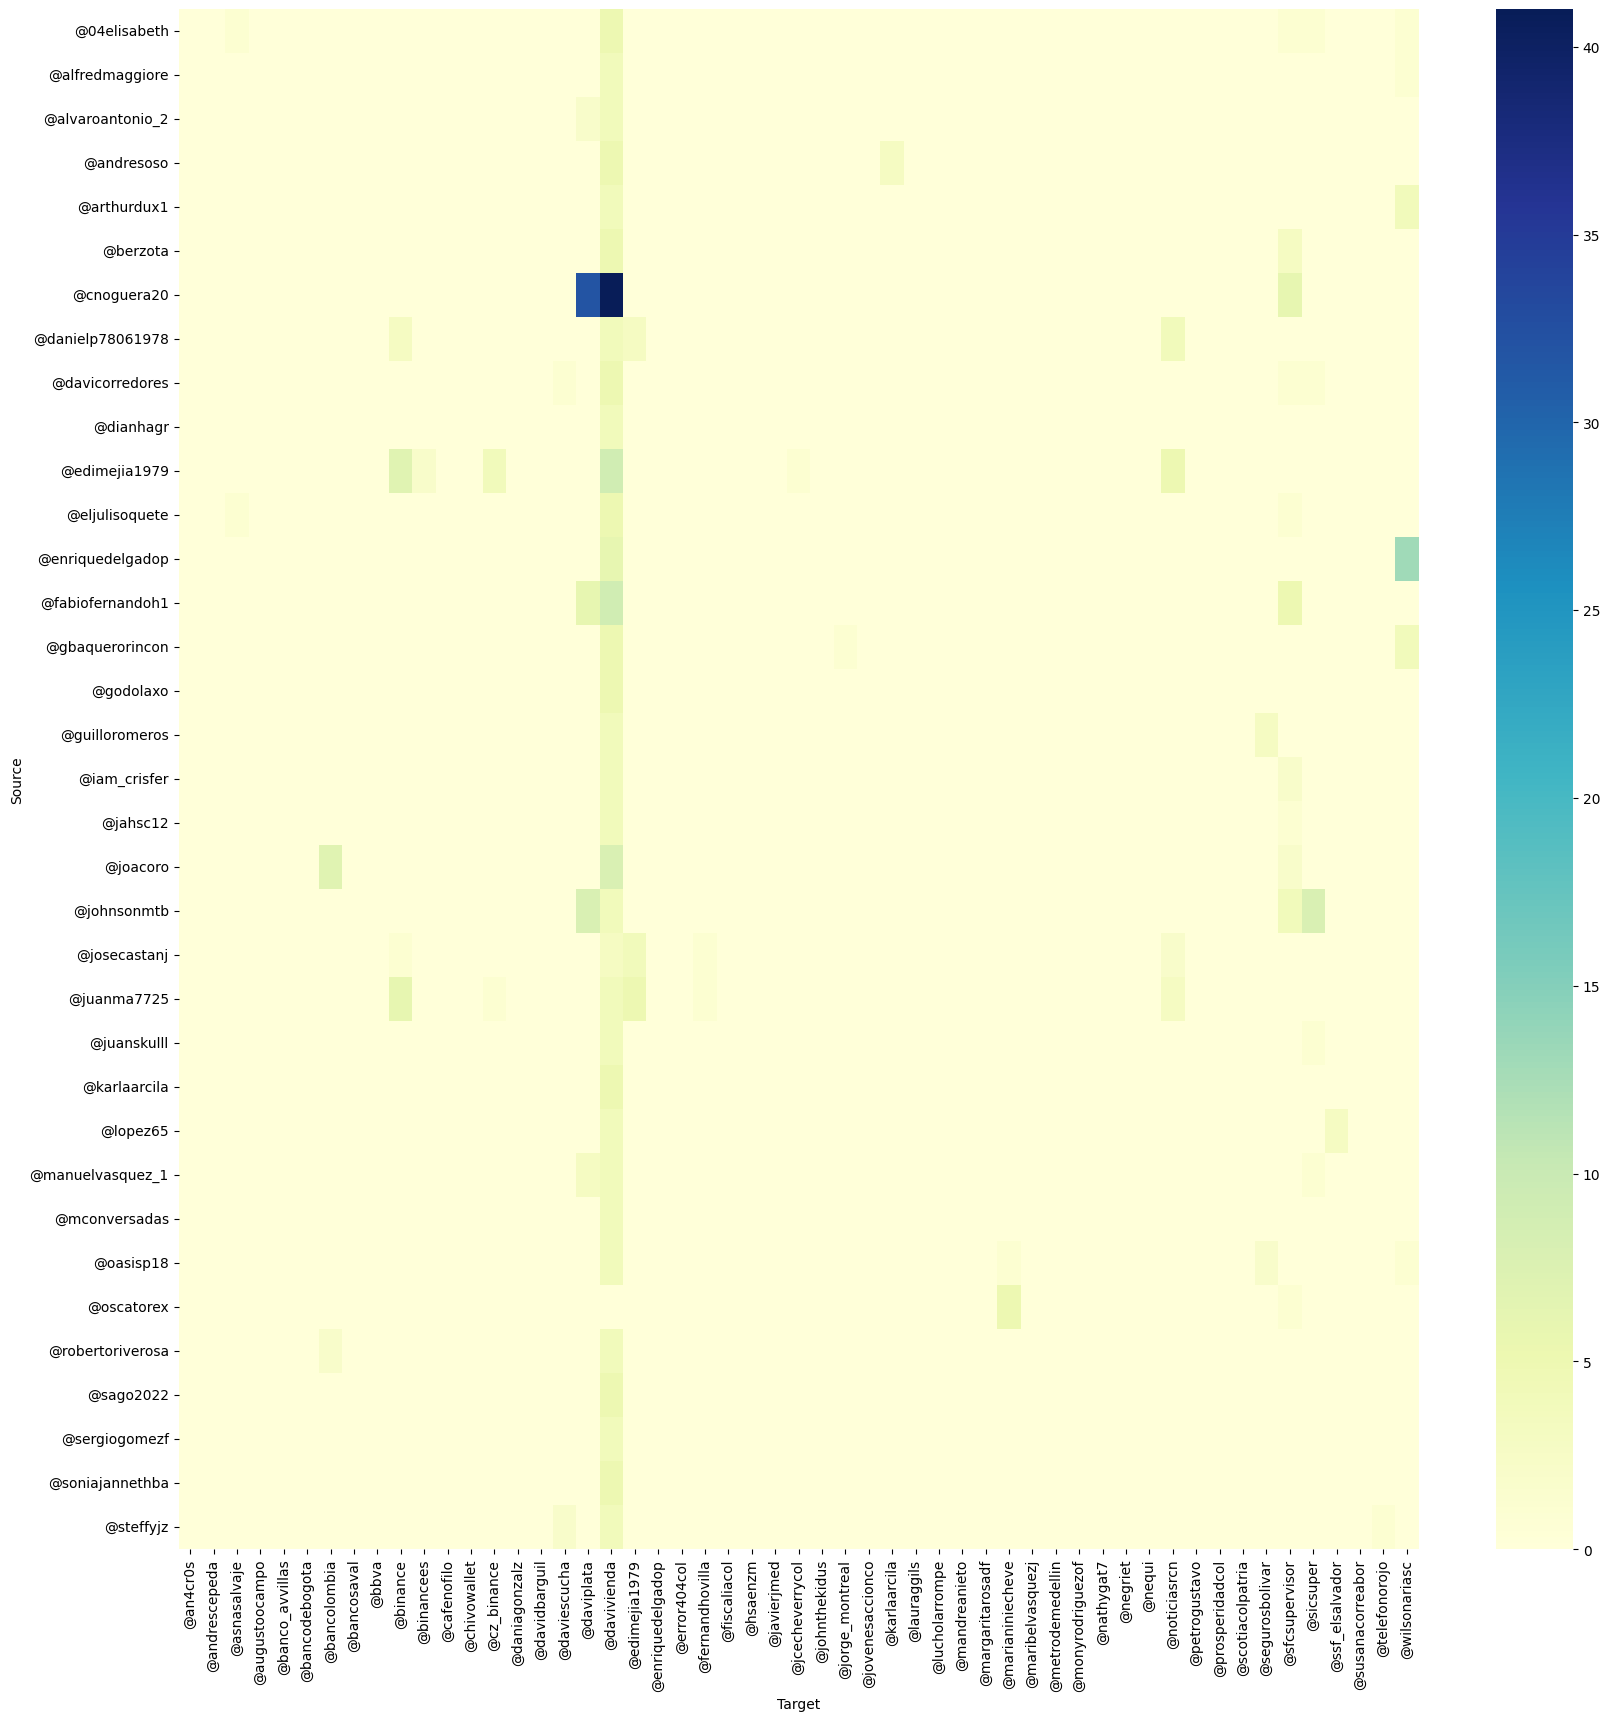

In [40]:
plt.figure(figsize=(20,20))
sns.heatmap(df_columns_heatmap,cmap="YlGnBu")

La mayoría de tweets hacen mencio a @Davivienda y @Daviplata. Resalta la mencion recurrente por parte el usuario @Cnoguera20.

In [41]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(set(list(df_1.Source)+list(df_1.Target)))
    ),
    link = dict(
      source = df_1['Source_num'], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = df_1['Target_num'],
      value = df_1['Weight']
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

Este gráfico muestra mejor la inter-relación entre los usuarios que se mencionan más de tres veces. La mayoría de tweets que tenemos muestran la comunicación constante entre los usuarios y el twitter de @davivienda, @daviplata y algunas necesidades de denuncia, pues se aprecia una gran cantidad de tweets que hacen referencia a @wilsonariasc (senador de la república), @sfcsupervisor (superfinanciera) y @noticiasrcn.

Revisando con más detalle tenemos:

In [42]:
## Las 20 cuentas que más menciones hacen

df_agrupacion_fuente.head(20)

,Source,Usuarios mencionados,Total de menciones
261,@davivienda,208,248
601,@juanma7725,11,27
940,@santini_es,10,10
251,@davicorredores,10,22
440,@guilloromeros,9,22
555,@johnsonmtb,8,40
234,@damarismarino,8,8
314,@edimejia1979,8,32
356,@enriquedelgadop,7,24
617,@julioorozco29,7,10


In [43]:
## Las 20 cuentas mas mencionadas

df_agrupacion_mencionados.head(20)

,Target,Usuarios que lo mencionaron,Total de menciones
212,@davivienda,746,1103
832,@wilsonariasc,80,106
752,@sfcsupervisor,63,88
211,@daviplata,57,121
554,@marianiniecheve,53,60
71,@asnasalvaje,45,47
93,@bancolombia,44,54
744,@segurosbolivar,32,39
756,@sicsuper,20,27
473,@karlaarcila,20,25


Veamos el sentimiento de los tweets

In [44]:
## Exploración de sentimientos se uso el modelo nlptown/bert-base-multilingual-uncased-sentiment de hugging face

sentimientos=pd.DataFrame(df_tweets_2['sentiment'].value_counts())
sentimientos

,sentiment
1 star,1250
5 stars,314
4 stars,152
3 stars,51
2 stars,44


In [45]:
px.pie(sentimientos, values='sentiment', names=sentimientos.index, title='Sentimientos de los tweets')

In [46]:
## relación usuarios y sentimientos

df_tweets_2.groupby(['sentiment']).agg({'UserName':'nunique'})


,UserName
sentiment,
1 star,936
2 stars,43
3 stars,48
4 stars,43
5 stars,175


In [47]:
## Aporte usuarios a los sentimientos

for i in df_tweets_2['sentiment'].unique():
    df_temp=df_tweets_2[df_tweets_2['sentiment']==i]
    df_temp=df_temp.groupby(['UserName']).agg({'sentiment':'count'})
    df_temp=df_temp.sort_values(by='sentiment',ascending=False)
    df_temp=df_temp.head(10)
    df_temp.reset_index(inplace=True)
    fig = px.bar(df_temp, x='UserName', y='sentiment',color='UserName',title='Usuarios que más aportan a los sentimientos {}'.format(i))
    fig.show()
    display(df_temp)
    

,UserName,sentiment
0,@davicorredores,2
1,@luisa_porras24,1
2,@majo27794550,1
3,@malubodeh,1
4,@mateomanrique82,1
5,@milu_mejia22,1
6,@nicodiazgr,1
7,@nxttxdxyy,1
8,@oscatorex,1
9,@perenguena,1


,UserName,sentiment
0,@davivienda,104
1,@quegolazodel10,3
2,@davicorredores,3
3,@daviescucha,2
4,@guilloromeros,2
5,@abcpublicitario,1
6,@navascarola,1
7,@ndazalopesierra,1
8,@oscatorex,1
9,@pandebonita,1


,UserName,sentiment
0,@davivienda,36
1,@cnoguera20,35
2,@edimejia1979,9
3,@juanma7725,7
4,@fabiofernandoh1,7
5,@enriquedelgadop,6
6,@joacoro,5
7,@nando79208857,5
8,@josecastanj,5
9,@andresoso,5


,UserName,sentiment
0,@davivienda,105
1,@davicorredores,14
2,@dataifx,6
3,@fundacionbd,5
4,@cnoguera20,3
5,@damarismarino,3
6,@mariamargiraldo,2
7,@la_republica,2
8,@guilloromeros,2
9,@mconversadas,2


,UserName,sentiment
0,@cnoguera20,3
1,@davicorredores,2
2,@21mrniceguy,1
3,@johantriana,1
4,@josefe71,1
5,@jota__ferro,1
6,@juanferdiazne,1
7,@juantailsb9,1
8,@kienyke,1
9,@ladelavid,1


In [48]:
## Exploración de los temas

df_tweets_2['Tema más probable'].value_counts()

1    947
0    316
2    304
3    244
Name: Tema más probable, dtype: int64

In [49]:
## Aporte de los temas a los sentimientos
df_tweets_2['Tema más probable']=df_tweets_2['Tema más probable'].replace(label_temas)
for i in df_tweets_2['sentiment'].unique():
    df_temp=df_tweets_2[df_tweets_2['sentiment']==i]
    df_temp=df_temp.groupby(['Tema más probable']).agg({'sentiment':'count'})
    df_temp=df_temp.sort_values(by='sentiment',ascending=False)
    df_temp=df_temp.head(10)
    df_temp.reset_index(inplace=True)
    fig = px.bar(df_temp, x='Tema más probable', y='sentiment',color='Tema más probable',title='Temas que más aportan a los sentimientos {}'.format(i))
    fig.show()
    display(df_temp)
    


,Tema más probable,sentiment
0,Dificultades de acceso al dinero,28
1,Tweets que de campañas publicitarias,10
2,Tweets con información que afecta a la opinión...,6


,Tema más probable,sentiment
0,Tweets que requieren procesos para validar inf...,110
1,Dificultades de acceso al dinero,15
2,Tweets que de campañas publicitarias,14
3,Tweets con información que afecta a la opinión...,13


,Tema más probable,sentiment
0,Dificultades de acceso al dinero,807
1,Tweets con información que afecta a la opinión...,220
2,Tweets que de campañas publicitarias,150
3,Tweets que requieren procesos para validar inf...,73


,Tema más probable,sentiment
0,Tweets que requieren procesos para validar inf...,118
1,Tweets con información que afecta a la opinión...,70
2,Dificultades de acceso al dinero,66
3,Tweets que de campañas publicitarias,60


,Tema más probable,sentiment
0,Dificultades de acceso al dinero,31
1,Tweets que de campañas publicitarias,10
2,Tweets con información que afecta a la opinión...,7
3,Tweets que requieren procesos para validar inf...,3


In [50]:
## Análisis de entidades

DF_entidades=pd.read_csv('../Datos/Tweets_entidades.csv')
DF_entidades['Texto']=DF_entidades['Texto'].str.lower()



### Exploración de las Organizaciones

DF_organizaciones=DF_entidades[DF_entidades['Ent']=='ORG']
DF_organizaciones_conteo=DF_organizaciones.groupby(['Texto']).agg({'Ent':'count'})
DF_organizaciones_conteo=DF_organizaciones_conteo.sort_values(by='Ent',ascending=False)
DF_organizaciones_conteo.head(12)

,Ent
Texto,
davivienda,207
bancolombia,75
daviplata,40
whatsapp,17
banco davivienda,9
banco de bogotá,8
segurosbolivar,7
pse,7
banco,7


In [51]:

### Exploración de las Locaciones

DF_locaciones=DF_entidades[DF_entidades['Ent']=='GPE']
DF_locaciones_conteo=DF_locaciones.groupby(['Texto']).agg({'Ent':'count'})
DF_locaciones_conteo=DF_locaciones_conteo.sort_values(by='Ent',ascending=False)
DF_locaciones_conteo.head(12)

,Ent
Texto,
colombia,47
davivienda,18
bogotá,10
cali,7
barranquilla,4
bancolombia,4
canadá,4
el salvador,4
bogota,3


In [52]:

### Exploración de las personas

DF_personas=DF_entidades[DF_entidades['Ent']=='PERSON']
DF_personas_conteo=DF_personas.groupby(['Texto']).agg({'Ent':'count'})
DF_personas_conteo=DF_personas_conteo.sort_values(by='Ent',ascending=False)
DF_personas_conteo.head(11)

,Ent
Texto,
davivienda,40
marianiniecheve,15
diego,7
laura,7
petro,6
karlaarcila,6
juan,6
efraín forero,5
jorge_montreal,5
